# Clustering particles

In [1]:
# Libraries ----
import sys  # type: ignore
import imageio  # type: ignore
import warnings
import numpy as np  # type: ignore
import pandas as pd  # type: ignore

from tqdm import tqdm  # type: ignore

sys.path.append('../modules')
import track_particles as tp  # type: ignore
import plot_tracking as plt_tp  # type: ignore
import plot_clustering as plt_cp  # type: ignore
import clustering_particles as cp  # type: ignore

# Global options ----
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)

## Global variables

In [2]:
input_path = "../input_files"
output_path = "../output_files"
log_path = "../logs"
input_generation_date = "2025-02-18"

video_name = "3n_3m_0f_240220_2"
n_particles = int(video_name[0])
save_figures = True
save_tracking = True
x_bounds = [0, 1080]
y_bounds = [90, 1830]
x_zoom = [0, 1080]
y_zoom = [0, 1920]

## Setting video information

In [3]:
# Load the video
reader = imageio.get_reader("{}/{}.mp4".format(input_path, video_name), "ffmpeg")

# Check the number of frames
num_frames = reader.count_frames()
print("Total frames: {}".format(num_frames))

# Extract a frame to inspect the content
time = 0
frame = reader.get_data(time)
print("Frames resolution: {} x {}".format(frame.shape[0], frame.shape[1]))

Total frames: 36000
Frames resolution: 1080 x 1920


In [4]:
df_tracked = pd.concat([
    pd.read_csv("{}/tracked_{}_0.csv".format(output_path, video_name), low_memory=False),
    pd.read_csv("{}/tracked_{}_1.csv".format(output_path, video_name), low_memory=False)#,
    # pd.read_csv("{}/tracked_{}_2.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_3.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_4.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_5.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_6.csv".format(output_path, video_name), low_memory=False),
    #pd.read_csv("{}/tracked_{}_7.csv".format(output_path, video_name), low_memory=False),
    # pd.read_csv("{}/tracked_{}_8.csv".format(output_path, video_name), low_memory=False)
]).sort_values(["id", "time"])

In [5]:
if "coords_x" in df_tracked.columns:
    df_tracked["coords_x"] = df_tracked["coords_x"].apply(lambda x: np.fromstring(x, sep=" "))
    df_tracked["coords_y"] = df_tracked["coords_y"].apply(lambda x: np.fromstring(x, sep=" "))
df_tracked.sort_values(["time", "id"]).head(2 * n_particles)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
0,0,0,1255.172858,11.511953,1254.089402,11.549474,0.0,1198.000000,0.000000,0.450980,1207.000000,0.000000,-1.565596,2719.0,130.825917,28.076115,0.976701,6
1,1,0,1614.560252,163.869588,1609.085819,163.174150,NaN,1614.560252,163.869588,NaN,1614.560252,163.869588,0.156844,13626.0,241.851958,84.807675,0.936503,6
2,2,0,254.328536,124.227237,256.354912,125.568024,NaN,254.328536,124.227237,NaN,254.328536,124.227237,1.447997,12784.0,246.153150,99.103036,0.915373,6
3,3,0,1332.258185,418.381197,1332.206818,418.327927,0.0,1305.000000,356.000000,0.494118,1306.000000,358.000000,0.567004,2138.0,115.230349,43.315589,0.926658,6
4,4,0,1365.665632,620.476260,1365.555082,620.336714,0.0,1361.000000,536.000000,0.509804,1406.000000,644.000000,-0.854941,5476.0,101.492079,93.670793,0.384951,6
5,5,0,1659.513413,755.552458,1657.928134,766.742186,0.0,1646.000000,649.000000,0.454902,1672.000000,660.000000,0.003155,10475.0,260.333761,66.498809,0.966826,6


In [6]:
# Manual Setup for time = 0
tracking_0 = df_tracked[df_tracked["time"] == 0]
cols = ["id", "time", "id_count", "position_x", "position_y", "orientation"]
print("Initial tracking at time 0:\n", tracking_0[cols])

if tracking_0.shape[0] != n_particles:
    # Manual fitting of initial time tracking
    tracking_0 = tracking_0.drop_duplicates(subset=["id"], keep="first")
    tracking_0 = tracking_0[tracking_0["id"].isin([1, 2, 5])]
    tracking_0["id"] = np.arange(n_particles)
    tracking_0["orientation"] = np.array([
        tracking_0["orientation"].values[0],
        -tracking_0["orientation"].values[1],
        tracking_0["orientation"].values[2]
    ])

    # Replace the manual setting
    df_tracked = pd.concat([
        tracking_0,
        df_tracked[df_tracked["time"] != 0]
    ]).sort_values(["id", "time"])

df_tracked.sort_values(["time", "id"]).head(2 * n_particles + 1)

Initial tracking at time 0:
    id  time  id_count   position_x  position_y  orientation
0   0     0         6  1255.172858   11.511953    -1.565596
1   1     0         6  1614.560252  163.869588     0.156844
2   2     0         6   254.328536  124.227237     1.447997
3   3     0         6  1332.258185  418.381197     0.567004
4   4     0         6  1365.665632  620.476260    -0.854941
5   5     0         6  1659.513413  755.552458     0.003155


,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
1,0,0,1614.560252,163.869588,1609.085819,163.174150,NaN,1614.560252,163.869588,NaN,1614.560252,163.869588,0.156844,13626.0,241.851958,84.807675,0.936503,6
2,1,0,254.328536,124.227237,256.354912,125.568024,NaN,254.328536,124.227237,NaN,254.328536,124.227237,-1.447997,12784.0,246.153150,99.103036,0.915373,6
5,2,0,1659.513413,755.552458,1657.928134,766.742186,0.0,1646.000000,649.000000,0.454902,1672.000000,660.000000,0.003155,10475.0,260.333761,66.498809,0.966826,6
6,0,3,1257.350844,11.016871,1256.337665,11.034503,0.0,1198.000000,1.000000,0.450980,1198.000000,0.000000,1.554697,2608.0,127.240044,27.182472,0.976914,6
7,1,3,1615.054822,164.077816,1609.966921,163.569071,NaN,1615.054822,164.077816,NaN,1615.054822,164.077816,0.160556,13699.0,241.461181,85.766379,0.934791,6
8,2,3,254.276336,124.242846,256.316775,125.604954,NaN,254.276336,124.242846,NaN,254.276336,124.242846,1.447775,12720.0,246.323240,99.027279,0.915630,6
9,3,3,1332.145368,418.019952,1332.096579,417.974462,0.0,1305.000000,356.000000,0.494118,1306.000000,357.000000,0.565214,2105.0,113.913184,44.400731,0.920909,6


In [7]:
df_tracked.sort_values(["time", "id"]).tail(5)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count
8946,0,35997,334.539906,10.360161,334.404445,10.362336,0.0,284.000000,0.000000,0.564706,286.000000,0.000000,1.537222,1491.0,99.440248,25.608965,0.966270,5
8947,1,35997,946.635472,7.239245,946.405970,7.250786,0.0,923.000000,3.000000,0.533333,904.000000,0.000000,-1.548809,1325.0,101.853759,18.512086,0.983344,5
8948,2,35997,479.683824,143.815833,484.251796,143.147939,0.0,452.000000,100.000000,0.666667,436.000000,185.000000,-1.443200,14552.0,249.966339,88.948689,0.934546,5
8949,3,35997,1633.956718,524.037195,1632.221267,531.500816,NaN,1633.956718,524.037195,NaN,1633.956718,524.037195,0.096706,11991.0,237.931562,73.392394,0.951237,5
8950,4,35997,1651.230807,790.106873,1644.416861,782.569994,0.0,1595.000000,685.000000,0.494118,1599.000000,693.000000,0.526500,10199.0,213.468536,74.148232,0.937736,5


## Velocities distribution in each frame

In [8]:
omega_threshold = np.pi / 2 # Angular velocity per frame
velocity_threshold = 94.0 # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi)

# Compute differences for each id
df_tracked["delta_time"] = df_tracked.groupby(["id"])["time"].diff()
df_tracked["velocity_x"] = df_tracked.groupby(["id"])["position_x"].diff()
df_tracked["velocity_y"] = df_tracked.groupby(["id"])["position_y"].diff()
df_tracked["velocity_orientation"] = df_tracked.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_tracked["velocity_x"] = df_tracked["velocity_x"] / df_tracked["delta_time"]
df_tracked["velocity_y"] = df_tracked["velocity_y"] / df_tracked["delta_time"]
df_tracked["velocity_orientation"] = df_tracked["velocity_orientation"] / df_tracked["delta_time"]

# Filter short jumps (highest velocities are False)
df_tracked["mask_x"] = np.where(np.abs(df_tracked["velocity_x"]) <= velocity_threshold, True, False)
df_tracked["mask_y"] = np.where(np.abs(df_tracked["velocity_y"]) <= velocity_threshold, True, False)
df_tracked["mask_orientation"] = np.where(np.abs(df_tracked["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 94.0 
	- Angle: 90.0


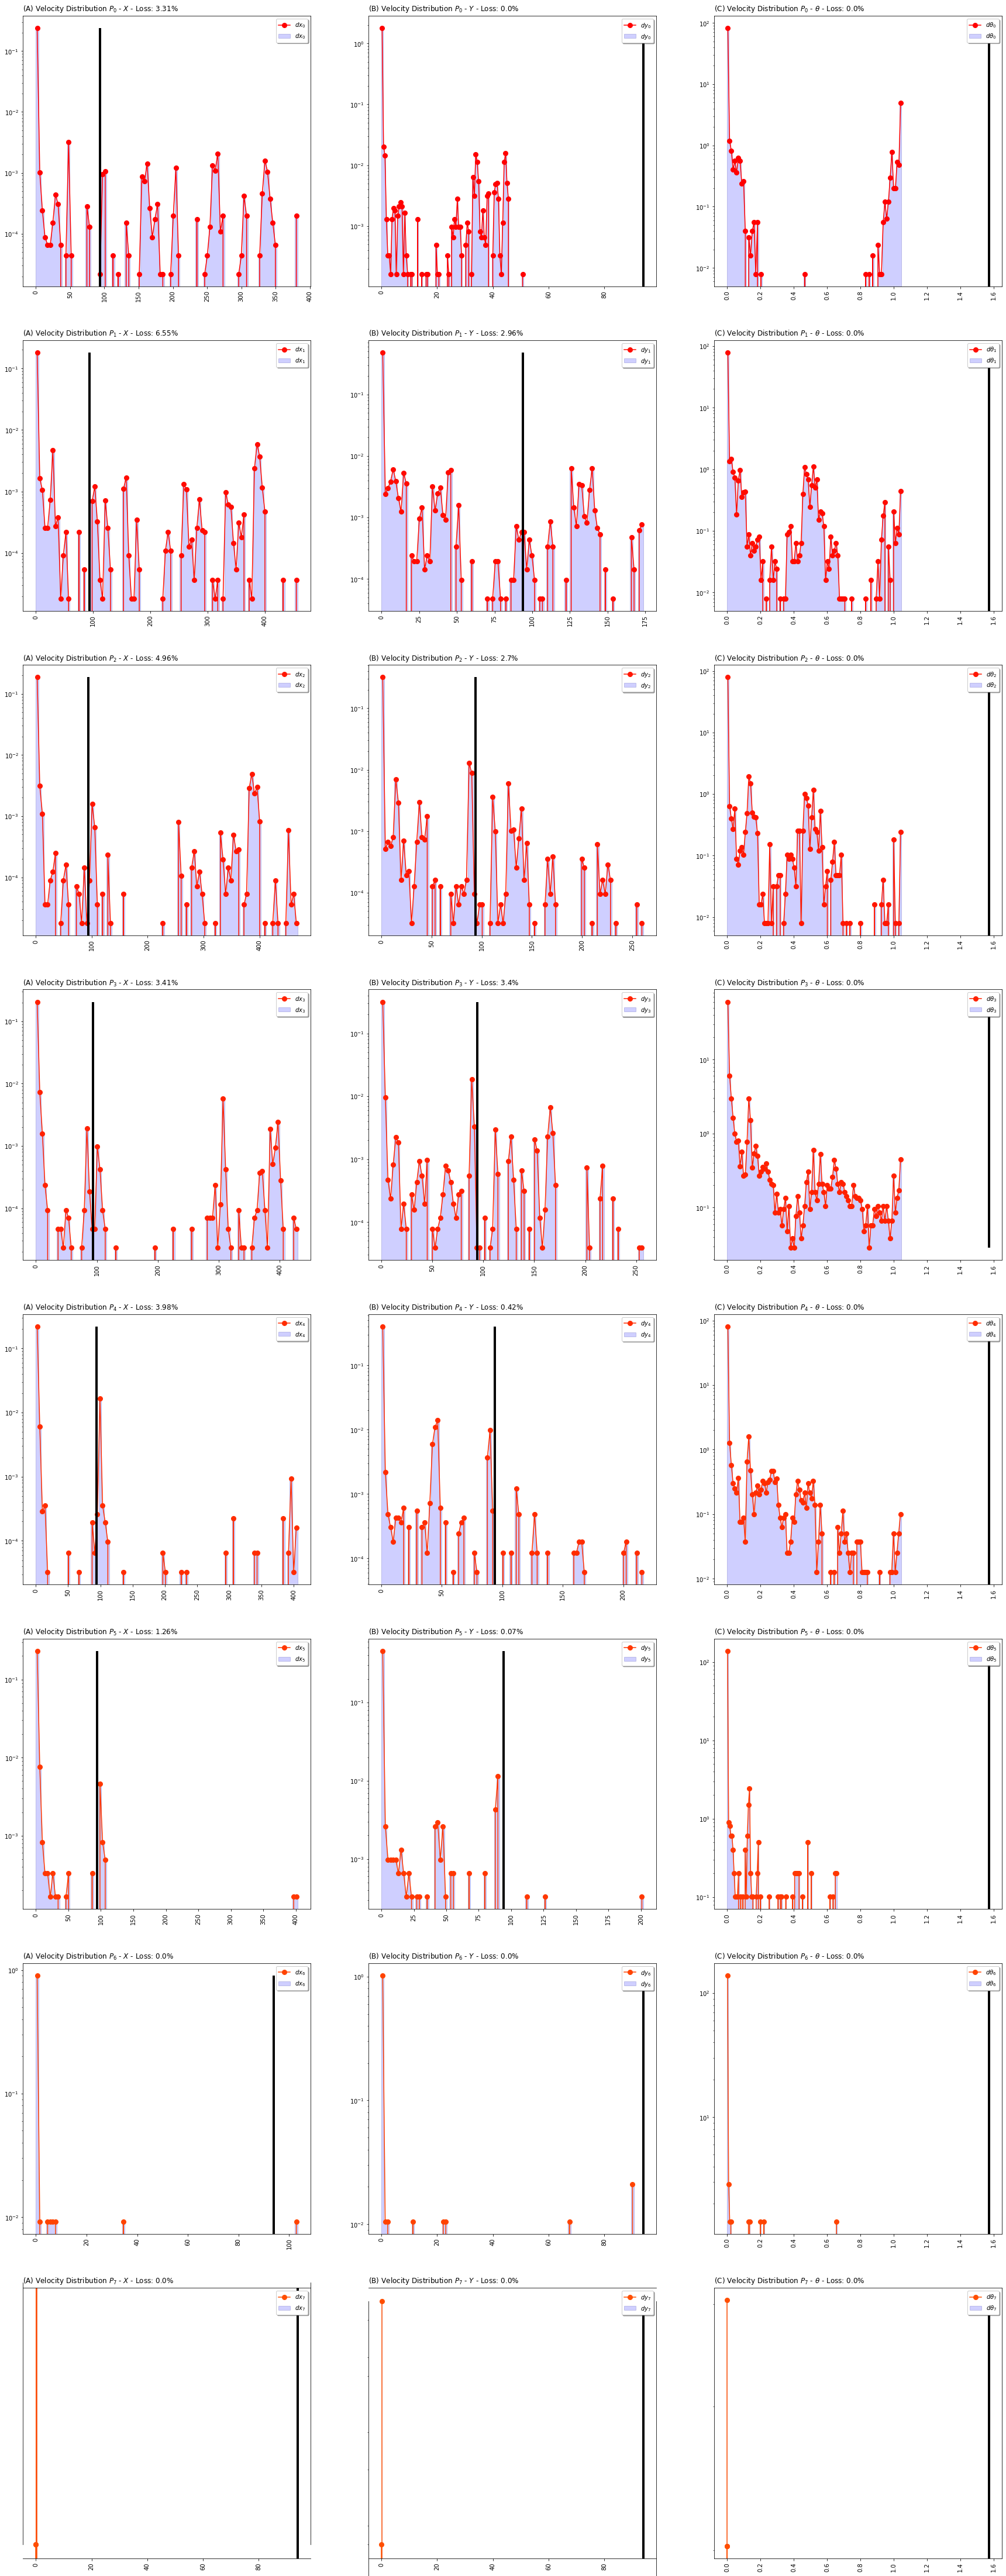

In [9]:
bins = 100
width = 10
fancy_legend = True

plt_cp.plot_velocities_distribution(
    df_tracked=df_tracked,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [10]:
df_tracked[["id_count"]].value_counts(dropna=False, sort=False, normalize=False).reset_index().sort_values("id_count")

,id_count,count
0,2,6
1,3,6033
2,4,9484
3,5,30525
4,6,8421
5,7,707
6,8,40


## Clustering frames

In [11]:
# id_count = df_tracked["id_count"].max()
type = "local equalized"
clip_limit = 0.05
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = 100 # Velocity per frame limited with half average size of particle
compare_bounds = False
similarity_threshold = 0.85

print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")
# ids = df_tracked[df_tracked["id_count"] != n_particles]["id_count"].unique()
# ids = sorted(np.sort(ids), key=lambda n: abs(n - n_particles))

df_clustered = cp.clustering_local_frames(
    reader=reader,
    df_tracked=df_tracked,
    weights_previous_time=[0],
    type=type,
    clip_limit=clip_limit,
    distance_threshold=velocity_threshold,
    compare_bounds=compare_bounds,
    similarity_threshold=similarity_threshold,
    n_particles=n_particles
)

Thresholds:
	- Velocity: 100 
	- Angle: 37.02449289972277 



In [12]:
df_clustered["id_count_new"] = df_clustered.groupby(["time"])["id"].transform("count")  # noqa: 501

### Explore final data

In [13]:
df_counts = (
    df_tracked[["id_count", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]
df_counts

,id_count,mask_x,mask_y,mask_orientation,proportion
0,2,False,False,False,0.009055
1,2,True,False,False,0.001811
2,3,False,False,False,10.163721
3,3,False,True,False,0.009055
4,3,True,False,False,0.070632
5,3,True,True,False,0.682773
6,4,False,False,False,15.973631
7,4,False,True,False,0.014489
8,4,True,False,False,0.626630
9,4,True,True,False,0.561431


In [14]:
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

# Compute differences for each id
df_clustered["delta_time"] = df_clustered.groupby(["id"])["time"].diff()
df_clustered["velocity_x"] = df_clustered.groupby(["id"])["position_x"].diff()
df_clustered["velocity_y"] = df_clustered.groupby(["id"])["position_y"].diff()
df_clustered["velocity_orientation"] = df_clustered.groupby(["id"])["orientation"].diff()

# Compute velocity components (change in position divided by change in time)
df_clustered["velocity_x"] = df_clustered["velocity_x"] / df_clustered["delta_time"]
df_clustered["velocity_y"] = df_clustered["velocity_y"] / df_clustered["delta_time"]
df_clustered["velocity_orientation"] = df_clustered["velocity_orientation"] / df_clustered["delta_time"]

# Filter short jumps (highest velocities are False)
df_clustered["mask_x"] = np.where(np.abs(df_clustered["velocity_x"]) <= velocity_threshold, True, False)
df_clustered["mask_y"] = np.where(np.abs(df_clustered["velocity_y"]) <= velocity_threshold, True, False)
df_clustered["mask_orientation"] = np.where(np.abs(df_clustered["velocity_orientation"]) <= omega_threshold, True, False)


Thresholds:
	- Velocity: 0.4711830316099561 
	- Angle: 37.02449289972277 



In [15]:
df_counts = (
    df_clustered[["id_count_new", "mask_x", "mask_y", "mask_orientation"]]
    .value_counts(dropna=False, sort=False, normalize=True)
    .reset_index()
    .sort_values(["id_count_new", "mask_x", "mask_y", "mask_orientation"])
)
df_counts["proportion"] = 100 * df_counts["proportion"]

print("Final loss data : {}%".format(df_counts[df_counts["id_count_new"]!=n_particles]["proportion"].sum()))
print("Final loss data X-axis: {}%".format(df_counts[df_counts["mask_x"]==False]["proportion"].sum()))
print("Final loss data Y-axis: {}%".format(df_counts[df_counts["mask_y"]==False]["proportion"].sum()))
print("Final loss data Angle : {}%".format(df_counts[df_counts["mask_orientation"]==False]["proportion"].sum()))
df_counts

Final loss data : 0.1027577970950093%
Final loss data X-axis: 2.5217318854667146%
Final loss data Y-axis: 2.2828894381648013%
Final loss data Angle : 0.2999416780070542%


,id_count_new,mask_x,mask_y,mask_orientation,proportion
0,3,False,False,False,0.116644
1,3,False,False,True,1.610798
2,3,False,True,False,0.052768
3,3,False,True,True,0.699864
4,3,True,False,False,0.005554
5,3,True,False,True,0.508235
6,3,True,True,False,0.116644
7,3,True,True,True,96.786736
8,4,False,False,False,0.005554
9,4,False,False,True,0.013886


In [16]:
df_filter_clustered = df_clustered[df_clustered["id_count_new"] == n_particles]
df_filter_clustered["id_count"] = df_filter_clustered["id_count_new"]
df_filter_clustered = df_filter_clustered.drop(columns=["id_count_new"])

Thresholds:
	- Velocity: 0.4711830316099561 
	- Angle: 37.02449289972277 



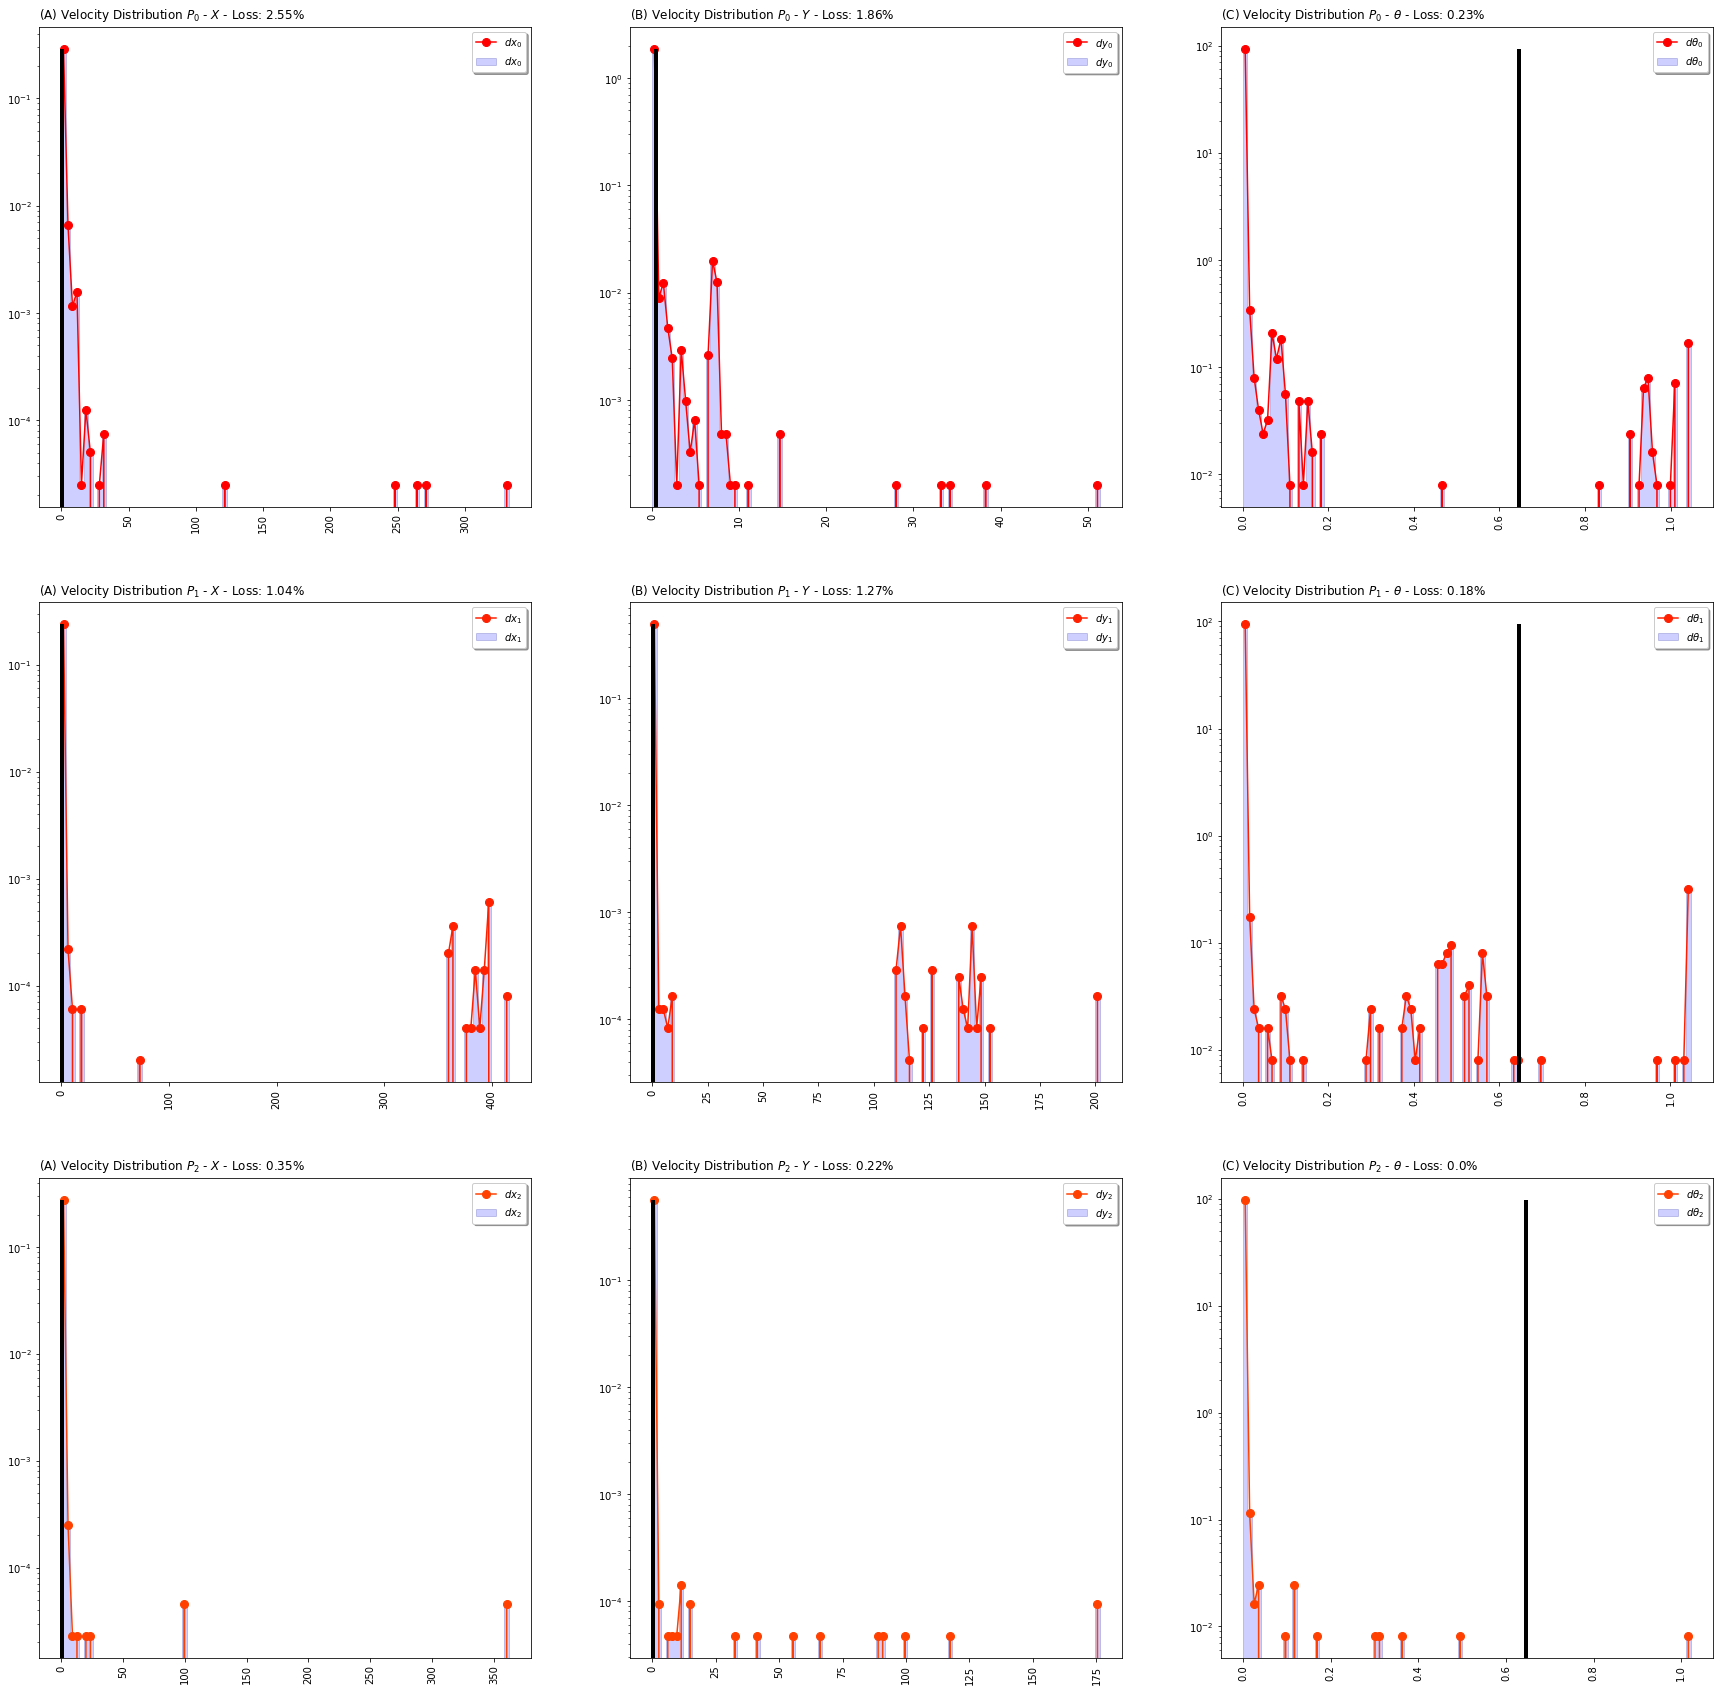

In [17]:
bins = 100
width = 10
fancy_legend = True
omega_threshold = df_tracked["velocity_orientation"].abs().quantile(0.965) # Angular velocity per frame
velocity_threshold = df_tracked["velocity_x"].abs().quantile(0.815) # Velocity per frame limited with half average size of particle
print("Thresholds:\n\t- Velocity:", velocity_threshold, "\n\t- Angle:", omega_threshold * 180 / np.pi, "\n")

plt_cp.plot_velocities_distribution(
    df_tracked=df_filter_clustered,
    bins=bins,
    velocity_threshold=velocity_threshold,
    omega_threshold=omega_threshold,
    width=width,
    fancy_legend=fancy_legend
)

In [18]:
if "coords_x" in df_filter_clustered.columns:
    df_filter_clustered.drop(columns=["coords_x", "coords_y"]).to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)
else:
    df_filter_clustered.to_csv("{}/clustered_{}.csv".format(output_path, video_name), index=False)

In [19]:
df_filter_clustered.head(n_particles * 3)

,id,time,position_x,position_y,weighted_x,weighted_y,darkest_v,darkest_x,darkest_y,lightest_v,lightest_x,lightest_y,orientation,area,axis_major,axis_minor,eccentricity,id_count,delta_time,velocity_x,velocity_y,velocity_orientation,mask_x,mask_y,mask_orientation
0,0,0,1614.560252,163.869588,1609.085819,163.174150,NaN,1614.560252,163.869588,NaN,1614.560252,163.869588,0.156844,13626.0,241.851958,84.807675,0.936503,3,NaN,NaN,NaN,NaN,False,False,False
2010,1,0,254.328536,124.227237,256.354912,125.568024,NaN,254.328536,124.227237,NaN,254.328536,124.227237,-1.447997,12784.0,246.153150,99.103036,0.915373,3,NaN,NaN,NaN,NaN,False,False,False
4020,2,0,1659.513413,755.552458,1657.928134,766.742186,0.0,1646.000000,649.000000,0.454902,1672.000000,660.000000,0.003155,10475.0,260.333761,66.498809,0.966826,3,NaN,NaN,NaN,NaN,False,False,False
6030,0,3,1615.054822,164.077816,1609.966921,163.569071,NaN,1615.054822,164.077816,NaN,1615.054822,164.077816,0.160556,13699.0,241.461181,85.766379,0.934791,3,3.0,0.164856,0.069409,0.001237,False,False,False
6031,1,3,254.276336,124.242846,256.316775,125.604954,NaN,254.276336,124.242846,NaN,254.276336,124.242846,1.447775,12720.0,246.323240,99.027279,0.915630,3,3.0,-0.017400,0.005203,0.965257,False,False,True
6032,2,3,1659.526235,755.583110,1657.997081,766.826054,0.0,1645.000000,649.000000,0.439216,1662.000000,662.000000,0.003634,10444.0,260.860384,66.585938,0.966874,3,3.0,0.004274,0.010217,0.000160,False,False,False
6033,0,6,1614.695442,163.770764,1609.261199,163.057264,NaN,1614.695442,163.770764,NaN,1614.695442,163.770764,0.157797,13449.0,241.752764,84.251354,0.937308,3,3.0,-0.119793,-0.102351,-0.000920,False,False,False
6034,1,6,254.400443,124.210347,256.468842,125.575936,NaN,254.400443,124.210347,NaN,254.400443,124.210347,1.448461,12641.0,246.001005,99.049320,0.915359,3,3.0,0.041369,-0.010833,0.000229,False,False,False
6035,2,6,1659.168857,755.071337,1656.898241,766.554121,0.0,1645.000000,649.000000,0.439216,1650.000000,661.000000,0.005496,10121.0,263.294700,63.820761,0.970178,3,3.0,-0.119126,-0.170591,0.000621,False,False,False


## Visualize final data

In [20]:
width = 10
n_x_breaks = 20
n_y_breaks = 20
x_bounds = x_bounds  # Range: [0, 1080]
y_bounds = y_bounds  # Range: [0, 1920]
x_zoom = None  # x_zoom
y_zoom = None  # y_zoom
fancy_legend = True
x_legend = 1.001
y_legend = 0.821

if save_figures:
    df_data = df_filter_clustered[["time", "id_count", "id"]].drop_duplicates()
    df_data["id_included"] = True
    df_data["orientation_included"] = True

    # for time in tqdm(df_filter_clustered["time"].unique()):
    for time in tqdm([0, 10, 20, 50, 100]):
        plt_tp.plot_tracking_frame(
            reader=reader,
            df_tracked_frame=df_filter_clustered,
            width=width,
            n_x_breaks=n_x_breaks,
            n_y_breaks=n_y_breaks,
            x_bounds=x_bounds,
            y_bounds=y_bounds,
            x_zoom=x_zoom,
            y_zoom=y_zoom,
            fancy_legend=fancy_legend,
            x_legend=x_legend,
            y_legend=y_legend,
            save_figure=True,
            output_path=output_path,
            output_name="{}_c".format(video_name),
            time=time
        )

    df_data.to_csv("{}/{}_c/df_control.csv".format(output_path, video_name), index=False)


100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


In [21]:
from shutil import make_archive

make_archive(
    "{}/{}_c".format(output_path, video_name),
    "zip",
    output_path,
    "{}/{}_c".format(output_path, video_name)
)

'/home/fabril/Github/High_Order_Interactions/tracking_videos/output_files/3n_3m_0f_240220_2_c.zip'